In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# Exercises

<div class="alert alert-block alert-info">

**1. Euler-Cromer**

A simple change to the first-order Euler method is to update the velocity first and then use the new velocity to evaluate the position:

$${\bf v}^{n+1} = {\bf v}^n + \tau \, {\bf a}({\bf r}^{n})$$

$${\bf r}^{n+1} = {\bf r}^n + \tau \, {\bf v}^{n+1}$$

    
This is called the *Euler-Cromer* method. 
In this sense, we are treating the position update implicitly.

Integrate the orbit problem with Euler-Cromer and compare to the standard Euler method.  Why do you think the solutions look so different if they are both first-order?
</div>

To make things simpler, we split the RHS routine into 2, one producing the update to position and one for velocity.

In [19]:
G = 4*np.pi**2
M_sun = 1.0

def rhs_r(t, Y):
    
    # unpack just to make things easier to read
    x, y, vx, vy = Y
    
    xdot = vx
    ydot = vy

    return np.array([xdot, ydot])

def rhs_v(t, Y):

    # unpack just to make things easier to read
    x, y, vx, vy = Y

    r = np.sqrt(x * x + y * y)
    
    vxdot = -G * M_sun * x / r**3
    vydot = -G * M_sun * y / r**3
    
    return np.array([vxdot, vydot])

In [20]:
class OrbitHistory:
    """store the time history of the orbit solution"""
    
    def __init__(self):
        self.t = []
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        
    def store_current_solution(self, t, Y):
        self.t.append(t)
        self.x.append(Y[0])
        self.y.append(Y[1])
        self.vx.append(Y[2])
        self.vy.append(Y[3])
        
    def plot(self, ax=None, label=None):
        """make a plot of the solution.  If ax is None we setup a figure
        and make the entire plot returning the figure object, otherwise, we
        just append the plot to a current axis"""

        fig = None
        
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)

            # draw the Sun
            ax.scatter([0], [0], marker=(20,1), color="y", s=250)

        # draw the orbit
        ax.plot(self.x, self.y, label=label)

        if fig is not None:
            ax.set_aspect("equal")
            ax.set_xlabel("x [AU]")
            ax.set_ylabel("y [AU]")
            
            return fig, ax

In [21]:
def initial_conditions():
    x0 = 0
    y0 = 1
    vx0 = -np.sqrt(G*M_sun/y0)
    vy0 = 0

    return np.array([x0, y0, vx0, vy0])

In [22]:
def euler_orbit(Y0, tau, T):
    
    # we'll return an orbit history object
    o = OrbitHistory()
    
    # storage for the new solution
    Y = Y0.copy()
    
    # initialize time
    t = 0
    
    # store the initial conditions
    o.store_current_solution(t, Y0)
    
    # main timestep loop
    while t < T:
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        Rdot = rhs_r(t, Y)
        Vdot = rhs_v(t, Y)
        
        Y[0] += tau * Rdot[0]
        Y[1] += tau * Rdot[1]

        Y[2] += tau * Vdot[0]
        Y[3] += tau * Vdot[1]

        t += tau
        
        # store the state
        o.store_current_solution(t, Y)
        
    return o
        

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='x [AU]', ylabel='y [AU]'>)

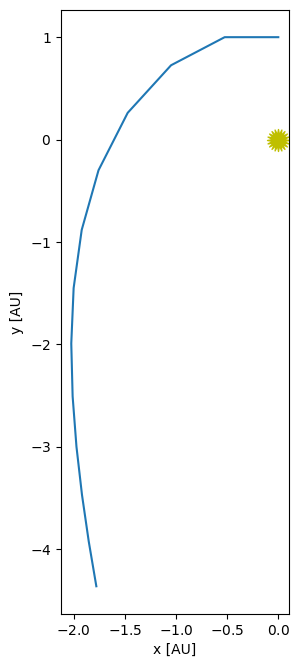

In [23]:
Y0 = initial_conditions()
tau = 1.0/12.0

orbit = euler_orbit(Y0, tau, 1)

orbit.plot()

In [24]:
def euler_cromer_orbit(Y0, tau, T):
    
    # we'll return an orbit history object
    o = OrbitHistory()
    
    # storage for the new solution
    Y = Y0.copy()
    
    # initialize time
    t = 0
    
    # store the initial conditions
    o.store_current_solution(t, Y0)
    
    # main timestep loop
    while t < T:
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        Vdot = rhs_v(t, Y)
                
        Y[2] += tau * Vdot[0]
        Y[3] += tau * Vdot[1]
        
        Rdot = rhs_r(t, Y)
        
        Y[0] += tau * Rdot[0]
        Y[1] += tau * Rdot[1]

        t += tau
        
        # store the state
        o.store_current_solution(t, Y)
        
    return o
        

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='x [AU]', ylabel='y [AU]'>)

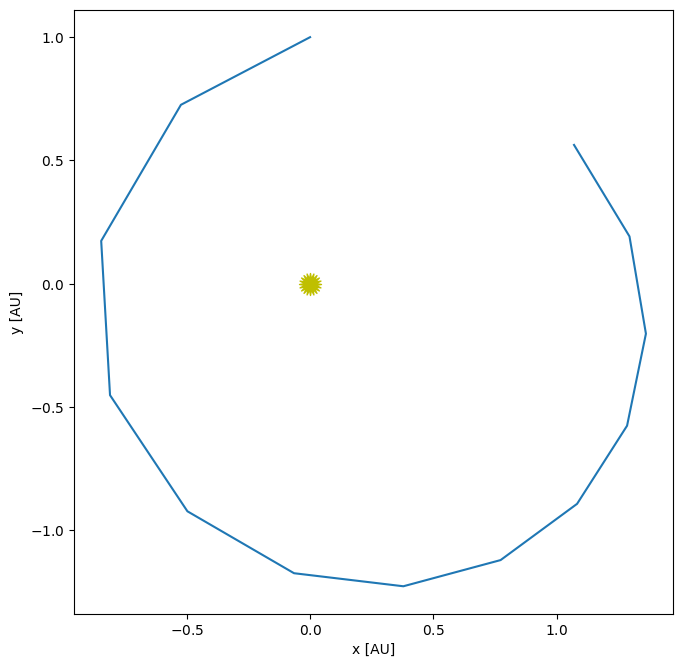

In [25]:
tau = 1.0/12.0

orbit = euler_cromer_orbit(Y0, tau, 1)
orbit.plot()

What's going on here?  Clearly the orbit looks a lot better for Euler-Cromer than just Euler.  

The reason is that Euler-Cromer actually conserves a discrete form of angular momentum, while standard Euler does not.  Euler-Cromer is an example of a [symplectic integrator](https://en.wikipedia.org/wiki/Symplectic_integrator).

<div class="alert alert-block alert-info">

**2. Energy conservation**

We can define the total energy / mass of our orbit system as:
    
$$\mathcal{E} = \frac{1}{2} |{\bf v}|^2 - \frac{GM_\star}{r}$$
    
since the mass of our planet does not change, this is conserved.  Plot $\mathcal{E}$ vs. time for the orbit for the different methods we looked at (including Euler-Cromer, from above).  How well do they conserve energy?
    
</div>

<div class="alert alert-block alert-info">

**3. Chaos**

The equations of motion for a double pendulum consisting of two equal length rigid rods are:
    
$$\dot{\theta}_1 = \frac{6}{I} \frac{2 {p_\theta}_1 - 3 \cos(\theta_1 - \theta_2) {p_\theta}_2}{16 - 9 \cos^2 (\theta_1 - \theta_2)}$$
    
$$\dot{\theta}_2 = \frac{6}{I} \frac{2 {p_\theta}_2 - 3 \cos(\theta_1 - \theta_2) {p_\theta}_1}{16 - 9 \cos^2 (\theta_1 - \theta_2)}$$
    
$${\dot{p}_\theta}_1 = -\frac{1}{2} I \left (\dot{\theta}_1\dot{\theta}_2 \sin(\theta_1 - \theta_2) + 3 \frac{g}{l} \sin \theta_1 \right )$$
    
$${\dot{p}_\theta}_2 = -\frac{1}{2} I \left (-\dot{\theta}_1\dot{\theta}_2 \sin(\theta_1 - \theta_2) +  \frac{g}{l} \sin \theta_2 \right )$$
    

where $I = m l^2$ is the moment of inertia, $\theta_1$ and $\theta_2$ are
the angles of the two rods with respect to the vertical and ${p_\theta}_1$
    and ${p_\theta}_2$ are generalized momenta.  See the [wikipedia page on double pendulum](https://en.wikipedia.org/wiki/Double_pendulum) for a derivation.

Write a routine to integrate this system using RK4, given initial angles
$\theta_1$ and $\theta_2$ (take the initial momenta to be 0).
    
    
A double pendulum system is nonlinear and can exhibit chaotic behavior&mdash;the solution at some time in the future depends sensitively on the initial conditions.  Make a plot of the solution you get ($\theta_1$ and $\theta_2$ vs. time) with two very closely spaced sets of initial conditions.  What happens to the evolution?
    

    
    
</div>

We'll take g = L to make it simpler.  One thing we need to be careful about is that the pendulum can flip over, so we want to restrict the angles to lie between $-\pi$ and $\pi$&mdash;this is accomplished by the `restrict_theta()` function below.

In [26]:
class DoublePendulum(object):
    """ a class to manage and integrate the double pendulum """

    def __init__(self, theta1, theta2, g=9.81, L=9.81, m=1.0):

        # initial conditions
        self.theta1_0 = np.radians(theta1)
        self.theta2_0 = np.radians(theta2)

        self.g = g

        # pendula are equal length and equal mass
        self.L = L
        self.m = m

        # final solution
        self.t = None
        self.theta1 = None
        self.theta2 = None

    def rhs(self, y):
        """ equations of motion for a double compound pendulum """

        theta1 = y[0]
        theta2 = y[1]
        p1 = y[2]
        p2 = y[3]

        # these are the equations of motion one gets from a Lagrangian
        # approach.  Note these assume a compound pendulum (e.g., a rod),
        # and the moment of inertia term is that for a rod.

        # moment of inertia-like term
        I = self.m*self.L**2

        denom = 16 - 9*np.cos(theta1 - theta2)**2
        t1dot = 6/I * (2*p1 - 3*np.cos(theta1 - theta2)*p2)/denom
        t2dot = 6/I * (8*p2 - 3*np.cos(theta1 - theta2)*p1)/denom

        p1dot = -0.5*I*(t1dot*t2dot*np.sin(theta1 - theta2) + 3*self.g*np.sin(theta1)/self.L)
        p2dot = -0.5*I*(-t1dot*t2dot*np.sin(theta1 - theta2) + self.g*np.sin(theta2)/self.L)

        return np.asarray([t1dot, t2dot, p1dot, p2dot])

    def integrate(self, dt, tmax):
        """ integrate the equations of motion using the RK4 """

        # initial conditions
        t = 0.0
        theta1 = self.theta1_0
        theta2 = self.theta2_0

        # start out at rest
        p1 = 0.0
        p2 = 0.0

        # store the history for plotting
        t_points = [t]
        theta1_points = [theta1]
        theta2_points = [theta2]

        y = np.asarray([theta1, theta2, p1, p2])

        while t < tmax:

            # get the RHS at time-level n
            k1 = self.rhs(y)
            k2 = self.rhs(y + 0.5*dt*k1)
            k3 = self.rhs(y + 0.5*dt*k2)
            k4 = self.rhs(y + dt*k3)

            ynew = y + dt/6.0 * (k1 + 2*k2 + 2*k3 + k4)

            t += dt

            # restrict theta
            ynew[0] = self.restrict_theta(ynew[0])
            ynew[1] = self.restrict_theta(ynew[1])

            # store
            t_points.append(t)
            theta1_points.append(ynew[0])
            theta2_points.append(ynew[1])

            # set for the next step
            y[:] = ynew[:]

        # store the entire solution
        self.t = np.asarray(t_points)
        self.theta1 = np.asarray(theta1_points)
        self.theta2 = np.asarray(theta2_points)


    def restrict_theta(self, theta):
        """convert theta in place to be restricted to lie between -pi and pi.
        This is done in a periodic fashion, with theta' = theta +/- 2n
        pi

        """

        # shift everything by pi, then restrict to lie between [0,
        # 2pi], then shift back by pi

        theta += np.pi
        theta += - 2.0*np.pi*np.floor(theta/(2.0*np.pi))
        theta -= np.pi

        return theta

In [27]:
dt = 0.05
tmax = 100.0

# run two double pendula with very close initial conditions
# they will diverge after some time

p_a = DoublePendulum(80, 10)
p_a.integrate(dt, tmax)

p_b = DoublePendulum(80.0001, 10.0001)
p_b.integrate(dt, tmax)

Text(0, 0.5, '$\\theta_2$')

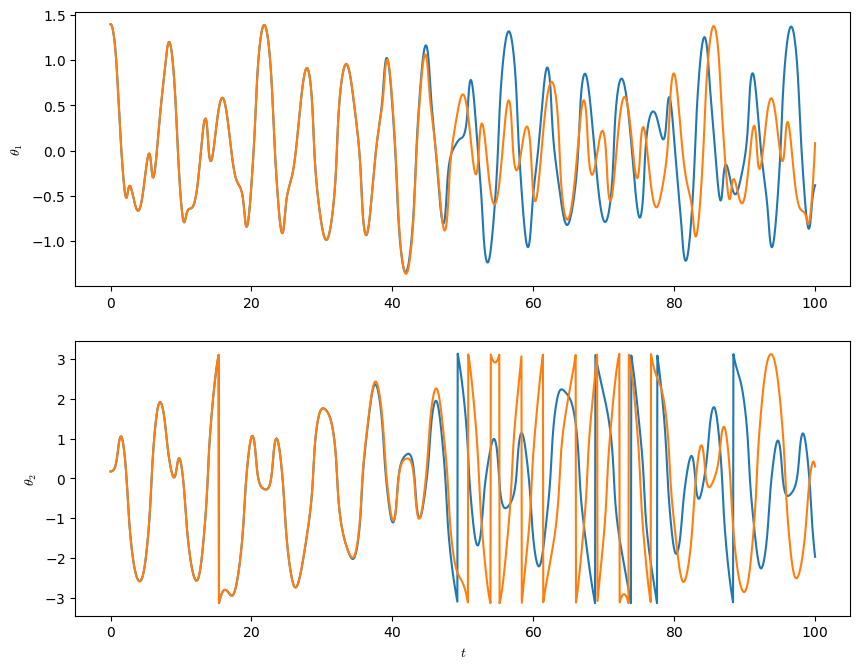

In [32]:
fig = plt.figure()

ax = fig.add_subplot(211)
ax.plot(p_a.t, p_a.theta1)
ax.plot(p_b.t, p_b.theta1)
ax.set_ylabel(r"$\theta_1$")

ax = fig.add_subplot(212)
ax.plot(p_a.t, p_a.theta2)
ax.plot(p_b.t, p_b.theta2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\theta_2$")
